C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0450 - val_loss: 0.0554
Epoch 2/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 0.0517
Epoch 3/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.7043e-04 - val_loss: 0.0515
Epoch 4/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.9449e-04 - val_loss: 0.0511
Epoch 5/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.3682e-04 - val_loss: 0.0512
Epoch 6/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.8288e-04 - val_loss: 0.0506
Epoch 7/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3697e-04 - val_loss: 0.0531
Epoch 8/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.9784e-04 - val_loss: 0.0449
Epoch 9/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.5288e-04 - val_loss: 0.0464
Epoch 10/10
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.5166e-04 - val_loss: 0.0452
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 2s 644us/step
Precision: 1.0000, Recall: 0.0622, F1-scor

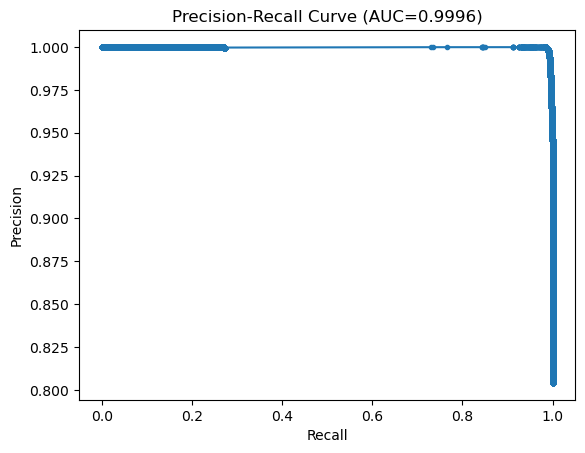

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("kddcup.data_10_percent_corrected", header=None)

# Define column names (KDD 99 has 41 features + 1 label)
columns = [f'feature_{i}' for i in range(41)] + ['label']
data.columns = columns

# Encode labels (Normal = 0, Attack = 1)
data['label'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Split features and labels
X = data.drop(columns=['label'])
y = data['label']

# Convert categorical features to numerical
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (normal data only) and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_normal = X_train[y_train == 0]  # Only normal data for training

# Build Autoencoder model
input_dim = X_train_normal.shape[1]
autoencoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')
])

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
history = autoencoder.fit(X_train_normal, X_train_normal, epochs=10, batch_size=64, validation_data=(X_test, X_test))

# Compute reconstruction error
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Set threshold (95th percentile)
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)

# Precision-Recall metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, mse)
pr_auc = auc(recall_vals, precision_vals)
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={pr_auc:.4f})')
plt.show()
